In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Measurement_first_row = session.query(Measurement).first()
Measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x181edf29fd0>,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
Station_first_row = session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x181edf76a58>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
#Determines earliest date
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()

#Determines most recent date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

#Determines date of 12 months prior
twelve_prior = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
twelve_prior


datetime.datetime(2016, 8, 23, 0, 0)

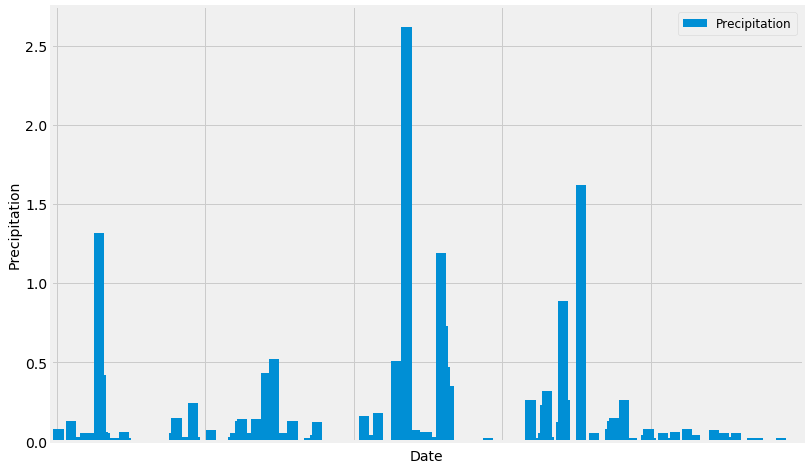

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_twelve_prcp_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= twelve_prior).group_by(Measurement.date).all()

last_twelve_prcp_data

# Calculate the date 1 year ago from the last data point in the database

twelve_prior_readable = (f'{twelve_prior.year}-{twelve_prior.month}-{twelve_prior.day}')
twelve_prior_readable

# Save the query results as a Pandas DataFrame and set the index to the date column

last_twelve_prcp_data_df = pd.DataFrame(last_twelve_prcp_data, columns=['Date', 'Precipitation'])

last_twelve_prcp_data_df.set_index('Date', inplace=True)

# Sort the dataframe by date
last_twelve_prcp_data_df = last_twelve_prcp_data_df.sort_values(by='Date',ascending=True)
last_twelve_prcp_data_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = last_twelve_prcp_data_df.plot(kind='bar', width=5, figsize=(14,10))
plt.locator_params(axis='x', nbins=5)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=14)
ax.grid(True)
plt.legend(bbox_to_anchor=(1,1), fontsize="12")
plt.ylabel("Precipitation", size=14)
plt.xlabel("Date", size=14)
plt.show


![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_twelve_prcp_data_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)? List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
THEE_most_active_station = most_active_stations[0][0]

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == THEE_most_active_station).all()


[(54.0, 71.66378066378067, 85.0)]

<function matplotlib.pyplot.show(*args, **kw)>

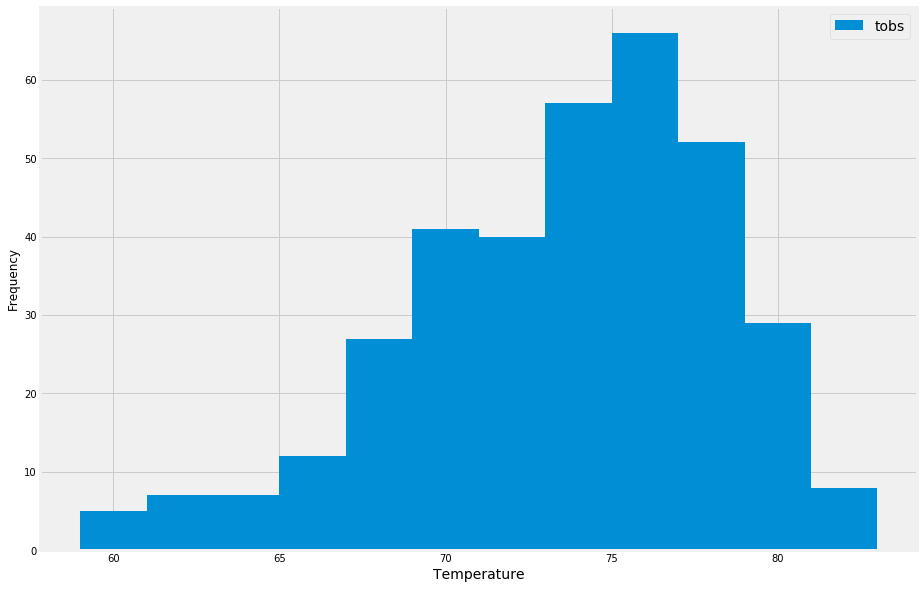

In [21]:
# Choose the station with the highest number of temperature observations and Query the last 12 months of temperature observation data
temps_for_THEE_station = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == THEE_most_active_station).\
                filter(Measurement.date >= twelve_prior).all()

#Convert to a dataframe
temps_for_THEE_station_df = pd.DataFrame(temps_for_THEE_station)
temps_for_THEE_station_df.set_index('station', inplace=True)
temps_for_THEE_station_df.head()

# Plot the results as a histogram
temps_for_THEE_station_df.plot.hist(by='station', bins=12, figsize=(14,10))
plt.locator_params(axis='x', nbins=7)
plt.xlabel("Temperature", fontsize=14)
plt.legend(bbox_to_anchor=(1,1), fontsize=14)

plt.show

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
trip_temps = calc_temps('2017-02-28', '2017-03-05')
trip_temps

[(64.0, 72.02777777777777, 78.0)]

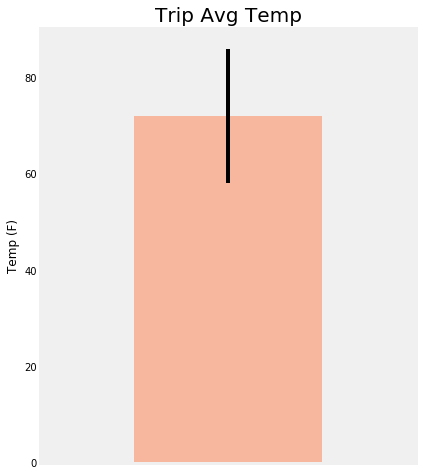

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_temps_df['Avg Temp']
min_max_temp = trip_temps_df.iloc[0]['Max Temp'] - trip_temps_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

In [57]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def total_rain(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.station, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
            group_by(Measurement.station).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            filter(Station.station == Measurement.station).all()

trip_rain = total_rain('2017-02-28', '2017-03-05')
trip_rain

trip_rain_df = pd.DataFrame(trip_rain, columns=['Station', 'Latitude', 'Longitude', 'Elevation', 'Percipitation'])

trip_rain_df.sort_values(by='Percipitation',ascending=False)
trip_rain_df


,Station,Latitude,Longitude,Elevation,Percipitation
0,USC00513117,21.42340,-157.80150,14.6,0.16
1,USC00514830,21.52130,-157.83740,7.0,0.04
2,USC00516128,21.33310,-157.80250,152.4,0.58
3,USC00517948,21.39340,-157.97510,11.9,NaN
4,USC00519281,21.45167,-157.84889,32.9,0.04
5,USC00519397,21.27160,-157.81680,3.0,0.00
6,USC00519523,21.33556,-157.71139,19.5,0.00


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


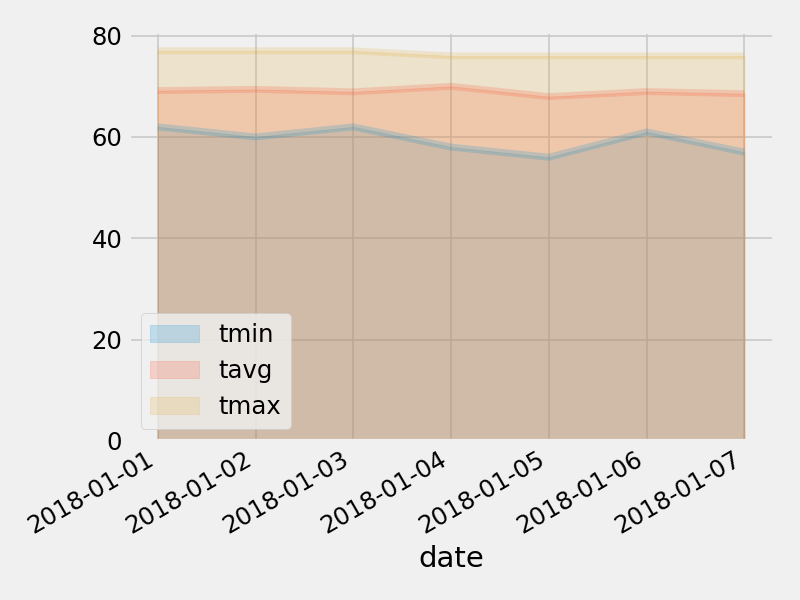

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
